## Stacked Regression

In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [107]:
#All imports
import os
import pandas as pd
import numpy as np
from datetime import datetime
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn import metrics

import statsmodels.api as sm

In [3]:
#list all the filenames
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


## Approach:
**=> Data Reading and Understanding<br>
=> Data Cleaning (Data Visualization, Null value treatment, Outlier treatment)<br>
=> Data Preparation (Converting categorical variables to numeric variables, Scaling)<br>
=> Model Building, Evaluation and Predictions on test set**

## Step 1 - Data Reading and Understanding

In [4]:
#Read the train data
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#Read the test data
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
train_Ids = train_df.pop('Id')
test_Ids = test_df.pop('Id')

test_df['SalePrice'] = np.NaN

In [7]:
housing_all_df = pd.concat([train_df, test_df], axis = 0, ignore_index=True)

In [8]:
print ("Train shape: ", train_df.shape)
print ("Test shape: ", test_df.shape)
print ("Combined shape: ", housing_all_df.shape)

Train shape:  (1460, 80)
Test shape:  (1459, 80)
Combined shape:  (2919, 80)


## Step 2 - Data Visualization and Cleaning

### Data Visualization

**Distribution of SalePrice column**

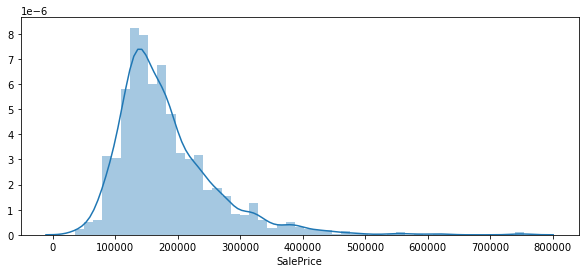

In [9]:
plt.figure(figsize=(10,4))
sns.distplot(housing_all_df[~housing_all_df['SalePrice'].isnull()]['SalePrice'])
plt.show()

**Visualization of Overall quality and SalePrice**

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x='OverallQual', y ='SalePrice', data=housing_all_df)
plt.show()

**Visualization of SalePrice and AboveGradeLivingArea**

In [ ]:
sns.scatterplot(x='GrLivArea', y= 'SalePrice', data = housing_all_df)
plt.show()

In [ ]:
sns.scatterplot(x='GrLivArea', y= 'SalePrice', hue='OverallQual', data = housing_all_df)
plt.show()

**Data Cleaning**

**Utilities**

In [10]:
#As column has no variance,dropping column: Utilities
housing_all_df.drop(columns=['Utilities'], inplace = True)

**Null value Imputation**

In [11]:
null_counts = housing_all_df.isnull().sum()
null_counts[null_counts.values > 0].index

Index(['MSZoning', 'LotFrontage', 'Alley', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SalePrice'],
      dtype='object')

**Impute MSZoning**

In [12]:
print(housing_all_df['MSZoning'].isnull().sum())
print (housing_all_df['MSZoning'].value_counts())

housing_all_df['MSZoning'].fillna(housing_all_df['MSZoning'].mode().values[0], inplace = True)

4
RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64


**Impute PoolQC**

In [13]:
#PoolQC
print (housing_all_df['PoolQC'].isnull().sum())
housing_all_df['PoolQC'].value_counts()

2909


Ex    4
Gd    4
Fa    2
Name: PoolQC, dtype: int64

In [14]:
housing_all_df[(housing_all_df['PoolQC'].isnull()) & (housing_all_df['PoolArea'] > 0)][['PoolArea','PoolQC','OverallQual']]

,PoolArea,PoolQC,OverallQual
2420,368,NaN,4
2503,444,NaN,6
2599,561,NaN,3


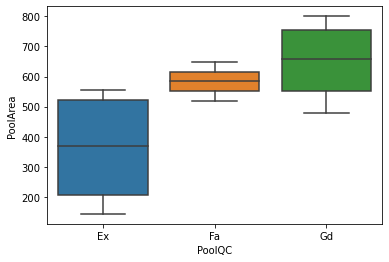

In [15]:
sns.boxplot(x='PoolQC', y='PoolArea', data=housing_all_df)
plt.show()

In [16]:
housing_all_df['PoolQC'].fillna(value='None', inplace=True)
housing_all_df['PoolQC'] = housing_all_df['PoolQC'].map({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

housing_all_df[housing_all_df.index == 2420]['PoolQC'] = 4
housing_all_df[housing_all_df.index == 2503]['PoolQC'] = 6
housing_all_df[housing_all_df.index == 2599]['PoolQC'] = 3

**Drop MiscFeatures and MiscVal**

In [17]:
housing_all_df.drop(columns=['MiscFeature','MiscVal'], inplace=True)

**Impute Alley**

In [18]:
print (housing_all_df['Alley'].isnull().sum())
housing_all_df['Alley'].value_counts()

housing_all_df['Alley'].fillna(value='None', inplace = True)

2721


**Impute Fence**

In [19]:
print (housing_all_df['Fence'].isnull().sum())
housing_all_df['Fence'].value_counts()

housing_all_df['Fence'].fillna(value='None', inplace=True)

2348


**Impute FireplaceQu**

In [20]:
housing_all_df['FireplaceQu'].fillna(value='None', inplace=True)

**Impute LotFrontage**

In [21]:
grouped_by_neighborhood = housing_all_df.groupby('Neighborhood')
lot_frontage_median = grouped_by_neighborhood['LotFrontage'].median()
lot_frontage_substitute = housing_all_df['Neighborhood'].map(lot_frontage_median.to_dict())
housing_all_df['LotFrontage'] = lot_frontage_substitute.where(pd.isnull(housing_all_df['LotFrontage']), housing_all_df['LotFrontage'])

**Impute GarageVariables**

In [22]:
housing_all_df['GarageYrBlt'] = housing_all_df['YearBuilt'].where(pd.isnull(housing_all_df['GarageYrBlt']), housing_all_df['GarageYrBlt'])
housing_all_df.loc[housing_all_df['GarageType'].isnull() & (housing_all_df['GarageArea'] == 0), 'GarageType'] = 'No Garage'
housing_all_df.loc[housing_all_df['GarageFinish'].isnull() & (housing_all_df['GarageArea'] == 0), 'GarageFinish'] = 'No Garage'
housing_all_df.loc[housing_all_df['GarageQual'].isnull() & (housing_all_df['GarageArea'] == 0), 'GarageQual'] = 'None'
housing_all_df.loc[housing_all_df['GarageCond'].isnull() & (housing_all_df['GarageArea'] == 0), 'GarageCond'] = 'None'

In [23]:
housing_all_df.loc[housing_all_df.index==2576, 'GarageCars']= 0
housing_all_df.loc[housing_all_df.index==2576, 'GarageArea']= 0
housing_all_df.loc[housing_all_df.index==2576, 'GarageType']= 'No Garage'
housing_all_df.loc[housing_all_df.index==2576, 'GarageFinish']= 'No Garage'
housing_all_df.loc[housing_all_df.index==2576, 'GarageQual']= 'None'
housing_all_df.loc[housing_all_df.index==2576, 'GarageCond']= 'None'

In [24]:
housing_all_df.loc[housing_all_df['GarageFinish'].isnull(),'GarageFinish'] = housing_all_df['GarageFinish'].mode().values[0]
housing_all_df.loc[housing_all_df['GarageCond'].isnull(),'GarageCond'] = housing_all_df['GarageCond'].mode().values[0]
housing_all_df.loc[housing_all_df['GarageQual'].isnull(),'GarageQual'] = housing_all_df['GarageQual'].mode().values[0]

**Impute Exterior1st**

In [25]:
print(housing_all_df['Exterior1st'].isnull().sum())
housing_all_df['Exterior1st'].value_counts()

housing_all_df['Exterior1st'].fillna(value=housing_all_df['Exterior1st'].mode().values[0], inplace=True)

1


**Impute Exterior2nd**

In [26]:
print(housing_all_df['Exterior2nd'].isnull().sum())
housing_all_df['Exterior2nd'].value_counts()

housing_all_df['Exterior2nd'].fillna(housing_all_df['Exterior2nd'].mode().values[0], inplace = True)

1


**Impute MasVnrType and MasVnrArea**

In [27]:
print (housing_all_df['MasVnrType'].isnull().sum())
housing_all_df['MasVnrType'].value_counts()

housing_all_df.loc[housing_all_df['MasVnrType'].isnull() & housing_all_df['MasVnrArea'].isnull(), 'MasVnrType'] = 'None'
housing_all_df.loc[housing_all_df['MasVnrType'].isnull() & housing_all_df['MasVnrArea'], 'MasVnrType'] = housing_all_df['MasVnrType'].mode().values[0]

24


In [28]:
housing_all_df['MasVnrArea'].fillna(value=0, inplace=True)

**Impute Basement variables**

In [29]:
housing_all_df.loc[housing_all_df['TotalBsmtSF'].isnull(),'BsmtFinSF1'] = 0
housing_all_df.loc[housing_all_df['TotalBsmtSF'].isnull(),'BsmtFinSF2'] =0
housing_all_df.loc[housing_all_df['TotalBsmtSF'].isnull(),'BsmtUnfSF'] =0
housing_all_df.loc[housing_all_df['TotalBsmtSF'].isnull(),'BsmtFullBath'] =0
housing_all_df.loc[housing_all_df['TotalBsmtSF'].isnull(),'BsmtHalfBath'] =0
housing_all_df.loc[housing_all_df['TotalBsmtSF'].isnull(),'TotalBsmtSF'] =0

In [30]:
housing_all_df.loc[(housing_all_df['TotalBsmtSF'] == 0) & (housing_all_df['BsmtQual'].isnull()), 'BsmtQual'] = 'None'
housing_all_df.loc[(housing_all_df['TotalBsmtSF'] == 0) & (housing_all_df['BsmtCond'].isnull()), 'BsmtCond'] = 'None'
housing_all_df.loc[(housing_all_df['TotalBsmtSF'] == 0) & (housing_all_df['BsmtExposure'].isnull()), 'BsmtExposure'] = 'None'
housing_all_df.loc[(housing_all_df['TotalBsmtSF'] == 0) & (housing_all_df['BsmtFinType1'].isnull()), 'BsmtFinType1'] = 'None'
housing_all_df.loc[(housing_all_df['TotalBsmtSF'] == 0) & (housing_all_df['BsmtFinType2'].isnull()), 'BsmtFinType2'] = 'None'

In [31]:
housing_all_df.loc[housing_all_df['BsmtQual'].isnull(), 'BsmtQual'] = housing_all_df['BsmtQual'].mode().values[0]
housing_all_df.loc[housing_all_df['BsmtCond'].isnull(), 'BsmtCond'] = housing_all_df['BsmtCond'].mode().values[0]
housing_all_df.loc[housing_all_df['BsmtExposure'].isnull(), 'BsmtExposure'] = housing_all_df['BsmtExposure'].mode().values[0]
housing_all_df.loc[housing_all_df['BsmtFinType2'].isnull(), 'BsmtFinType2'] = housing_all_df['BsmtFinType2'].mode().values[0]
housing_all_df.loc[housing_all_df['BsmtFullBath'].isnull(), 'BsmtFullBath'] = 0
housing_all_df.loc[housing_all_df['BsmtHalfBath'].isnull(), 'BsmtHalfBath'] = 0

**Impute Electrical**

In [32]:
print(housing_all_df['Electrical'].isnull().sum())
housing_all_df['Electrical'].value_counts()

housing_all_df['Electrical'].fillna(housing_all_df['Electrical'].mode().values[0], inplace=True)

1


**Impute KitchenQual**

In [33]:
print(housing_all_df['KitchenQual'].isnull().sum())
housing_all_df['KitchenQual'].value_counts()

housing_all_df['KitchenQual'].fillna(housing_all_df['KitchenQual'].mode().values[0], inplace=True)

1


**Impute Functional**

In [34]:
print(housing_all_df['Functional'].isnull().sum())
housing_all_df['Functional'].value_counts()

housing_all_df['Functional'].fillna(housing_all_df['Functional'].mode().values[0], inplace = True)

2


**Impute SaleType**

In [35]:
print(housing_all_df['SaleType'].isnull().sum())
housing_all_df['SaleType'].value_counts()

housing_all_df['SaleType'].fillna(housing_all_df['SaleType'].mode().values[0], inplace=True)

1


**Feature Engineering**

**Compute TotalBathroom from all types of bathrooms**

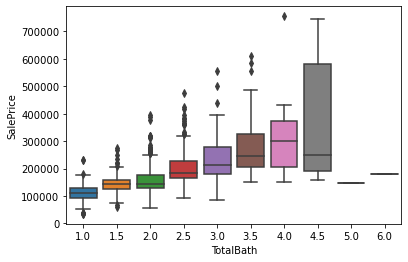

In [36]:
housing_all_df['TotalBath'] = housing_all_df['FullBath'] + housing_all_df['HalfBath'] * 0.5 + housing_all_df['BsmtFullBath'] + housing_all_df['BsmtHalfBath']*0.5

sns.boxplot(x='TotalBath', y ='SalePrice', data = housing_all_df[~housing_all_df['SalePrice'].isnull()])
plt.show()

**Compute HouseAge**

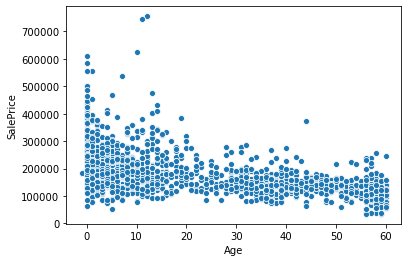

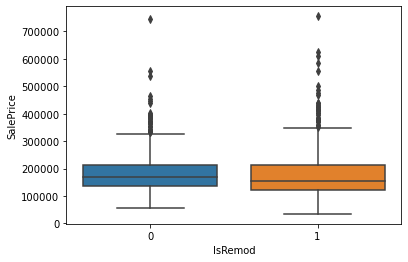

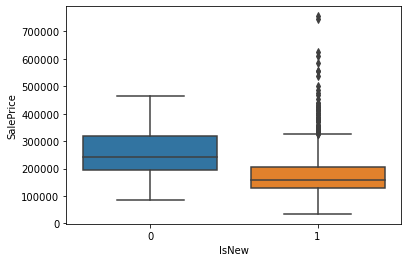

In [37]:
housing_all_df['IsRemod'] = np.where(housing_all_df['YearBuilt'] == housing_all_df['YearRemodAdd'], 0,1)
housing_all_df['Age'] = housing_all_df['YrSold'] - housing_all_df['YearRemodAdd']
                                                                  
sns.scatterplot(x='Age', y='SalePrice', data = housing_all_df[~housing_all_df['SalePrice'].isnull()])
plt.show()
                                                                  
sns.boxplot(x='IsRemod', y='SalePrice', data = housing_all_df[~housing_all_df['SalePrice'].isnull()])
plt.show()
                                                                  
housing_all_df['IsNew'] = np.where(housing_all_df['YearBuilt'] == housing_all_df['YrSold'], 0, 1)
                                                                  
sns.boxplot(x='IsNew', y='SalePrice', data = housing_all_df[~housing_all_df['SalePrice'].isnull()])
plt.show()                                                             

**Compute TotalArea**

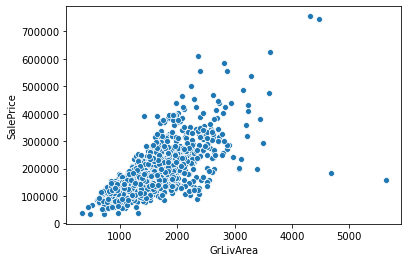

,GrLivArea,SalePrice
GrLivArea,1.000000,0.708624
SalePrice,0.708624,1.000000


In [38]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=housing_all_df[~housing_all_df['SalePrice'].isnull()])
plt.show()

housing_all_df[['GrLivArea','SalePrice']].corr()

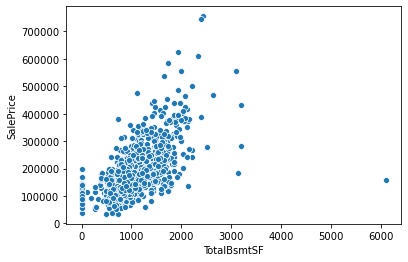

,SalePrice,TotalBsmtSF
SalePrice,1.000000,0.613581
TotalBsmtSF,0.613581,1.000000


In [39]:
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=housing_all_df[~housing_all_df['SalePrice'].isnull()])
plt.show()

housing_all_df[['SalePrice','TotalBsmtSF']].corr()

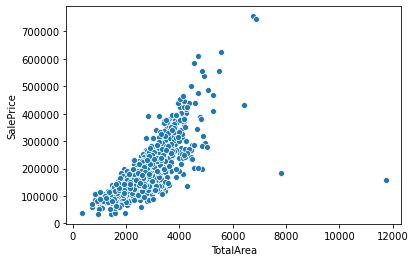

,TotalArea,SalePrice
TotalArea,1.000000,0.778959
SalePrice,0.778959,1.000000


In [40]:
housing_all_df['TotalArea'] = housing_all_df['GrLivArea'] + housing_all_df['TotalBsmtSF']

sns.scatterplot(x='TotalArea', y='SalePrice', data=housing_all_df)
plt.show()

housing_all_df[['TotalArea','SalePrice']].corr()

**Compute TotalPorchArea**

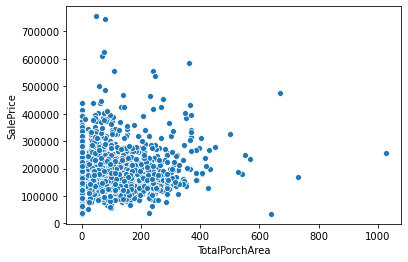

,TotalPorchArea,SalePrice
TotalPorchArea,1.000000,0.195739
SalePrice,0.195739,1.000000


In [41]:
housing_all_df['TotalPorchArea'] = housing_all_df['OpenPorchSF'] + housing_all_df['EnclosedPorch'] + housing_all_df['3SsnPorch'] + housing_all_df['ScreenPorch']

sns.scatterplot(x='TotalPorchArea', y='SalePrice',data=housing_all_df[~housing_all_df['SalePrice'].isnull()])
plt.show()

housing_all_df[['TotalPorchArea', 'SalePrice']].corr()

**Check correlations amongst numerical columns and drop the ones with high correlation**

In [42]:
numerical_cols = housing_all_df.select_dtypes(include='number').columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['MSSubClass', 'OverallQual','OverallCond','PoolQC','MoSold']]
housing_corr = housing_all_df[numerical_cols].corr()

In [ ]:
high_corr_matrix = housing_corr[abs(housing_corr.loc[:,:]) >= 0.5]
high_corr_matrix.to_csv('./correlations.csv')

**YearBuilt and GarageYrBlt has correlation of 0.85<br>Age and YearRemodAdd has a correlation has -0.99<br>1stFlrSF and TotalBsmtSF has a correlation of 0.80<br>TotalArea and TotalBsmtSF has a correlation of 0.82<br>TotalRoomsAbvGrd and GrLivArea has a correlation of 0.80<br>TotalArea and GrLivArea has a correlation of 0.87<br>GarageCars and GarageArea has a correlation of 0.88**

In [43]:
cols_to_drop = ['GarageYrBlt','YearRemodAdd','1stFlrSF','TotalBsmtSF','TotRmsAbvGrd','GrLivArea','GarageArea']
housing_all_df.drop(columns=cols_to_drop, inplace=True)

**Outlier treatment**

In [44]:
train_df[train_df['OverallQual'] == 10][['GrLivArea', 'SalePrice']].sort_values('GrLivArea', ascending=False)

,GrLivArea,SalePrice
1298,5642,160000
523,4676,184750
1182,4476,745000
691,4316,755000
1169,3627,625000
185,3608,475000
58,2945,438780
583,2775,325000
1373,2633,466500
440,2402,555000


In [45]:
#dropping the houses with index 1298 and 523
housing_all_df.drop(index=[523,1298], inplace=True)

**Skewness treatment of numerical columns**

In [46]:
numerical_cols = housing_all_df.select_dtypes(include='number').columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['MSSubClass','OverallQual','OverallCond','PoolQC','MoSold','SalePrice','IsRemod','IsNew','YearBuilt','YrSold']]

In [47]:
#treat skewness of numerical columns
for col in numerical_cols:
    skew_val = scipy.stats.skew(housing_all_df[col])
    if abs(skew_val) > 0.8:
        housing_all_df[col] = np.log(housing_all_df[col] + 1)    

In [48]:
#checking skewness of numerical cols
for col in numerical_cols:
    print ("feature: {0} skewness: {1}".format(col, scipy.stats.skew(housing_all_df[col])))

feature: LotFrontage skewness: -1.0688657005663162
feature: LotArea skewness: -0.5326457124687093
feature: MasVnrArea skewness: 0.538454299570571
feature: BsmtFinSF1 skewness: -0.6164909745064221
feature: BsmtFinSF2 skewness: 2.461259370788269
feature: BsmtUnfSF skewness: -2.154141950697556
feature: 2ndFlrSF skewness: 0.3066281842793695
feature: LowQualFinSF skewness: 8.554639154118071
feature: BsmtFullBath skewness: 0.6224147581878653
feature: BsmtHalfBath skewness: 3.773207852775839
feature: FullBath skewness: 0.16551425598450573
feature: HalfBath skewness: 0.696665956639074
feature: BedroomAbvGr skewness: 0.32656827186060494
feature: KitchenAbvGr skewness: 3.518883160679614
feature: Fireplaces skewness: 0.7252779166421299
feature: GarageCars skewness: -0.2192972271454799
feature: WoodDeckSF skewness: 0.1595229862313794
feature: OpenPorchSF skewness: -0.04153806962373557
feature: EnclosedPorch skewness: 1.9599516133804846
feature: 3SsnPorch skewness: 8.82211635359757
feature: ScreenP

**Data preparation**

In [49]:
for col in ['FireplaceQu', 'ExterQual', 'ExterCond', 'BsmtQual','BsmtCond','KitchenQual','GarageQual','GarageCond','HeatingQC']:
    housing_all_df[col] = housing_all_df[col].map({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    
housing_all_df['BsmtExposure'] = housing_all_df['BsmtExposure'].map({'None':0,'No':1,'Mn':2,'Av':3,'Gd':4})

for col in ['BsmtFinType1','BsmtFinType2']:
    housing_all_df[col] = housing_all_df[col].map({'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
    
housing_all_df['GarageFinish'] = housing_all_df['GarageFinish'].map({'No Garage':0,'Unf':1,'RFn':2,'Fin':3})

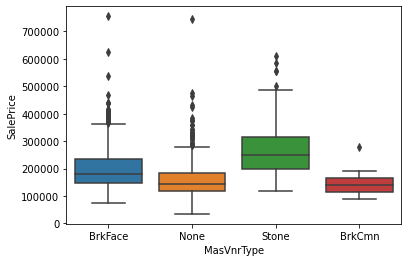

In [50]:
sns.boxplot(x='MasVnrType', y = 'SalePrice', data=housing_all_df)
plt.show()

housing_all_df['MasVnrType'] = housing_all_df['MasVnrType'].map({'None':0, 'BrkCmn':0, 'BrkFace':1, 'Stone':2}) 

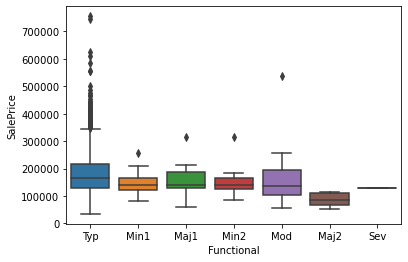

In [51]:
sns.boxplot(x='Functional', y = 'SalePrice', data=housing_all_df)
plt.show()

housing_all_df['Functional'] = housing_all_df['Functional'].map({'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,
                                                                 'Min1':6,'Typ':7}) 

**Combining neighborhood categories**

In [52]:
groupd_by_neighborhood = housing_all_df[~housing_all_df['SalePrice'].isnull()].groupby('Neighborhood')
neighborhood_median_prices = groupd_by_neighborhood['SalePrice'].median()
neighborhood_median_prices = neighborhood_median_prices.sort_values()

neighborhood_mean_prices = groupd_by_neighborhood['SalePrice'].mean()
neighborhood_mean_prices = neighborhood_mean_prices.sort_values()

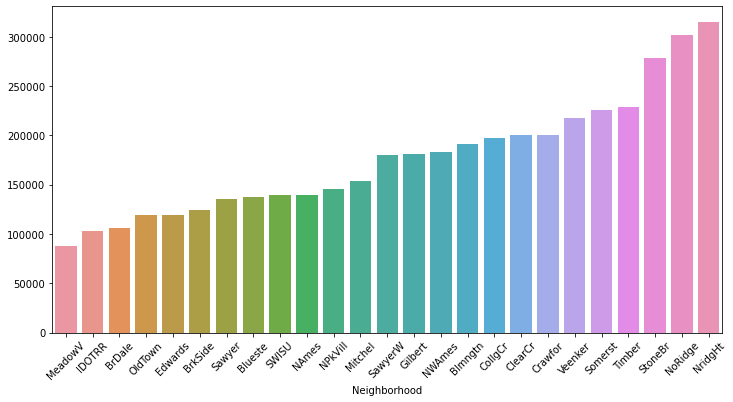

In [53]:
plt.figure(figsize=(12,6))
sns.barplot(x=neighborhood_median_prices.index, y = neighborhood_median_prices.values)
plt.xticks(rotation=45)
plt.show()

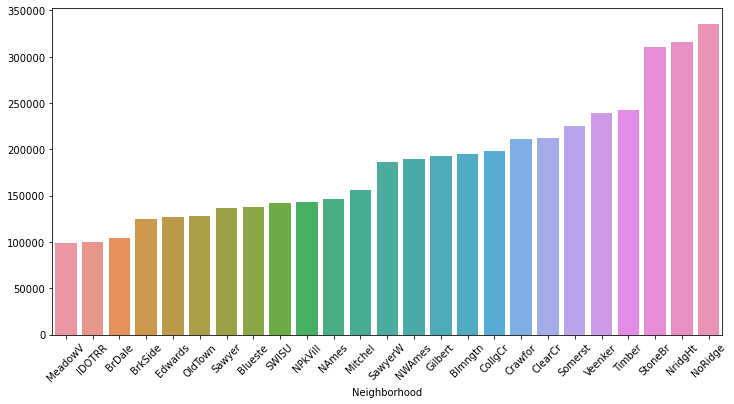

In [54]:
plt.figure(figsize=(12,6))
sns.barplot(x=neighborhood_mean_prices.index, y = neighborhood_mean_prices.values)
plt.xticks(rotation=45)
plt.show()

In [55]:
housing_all_df.loc[~housing_all_df['Neighborhood'].isin(['StoneBr','NridgHt','NoRidge','MeadowV','IDOTRR','BrDale']), 'Neighborhood'] = 1
housing_all_df.loc[housing_all_df['Neighborhood'].isin(['StoneBr','NridgHt','NoRidge']), 'Neighborhood'] = 2
housing_all_df.loc[housing_all_df['Neighborhood'].isin(['MeadowV','IDOTRR','BrDale']), 'Neighborhood'] = 0

In [56]:
housing_all_df['Neighborhood'] = housing_all_df['Neighborhood'].astype(int)

**Convert categories into dummies using one-hot encoding**

In [57]:
all_dummies = []
cat_cols = housing_all_df.select_dtypes(include='object').columns.tolist()
cat_cols.extend(['MSSubClass', 'MoSold','YrSold'])
for col in cat_cols:
    dummies = pd.get_dummies(housing_all_df[col], prefix=col, prefix_sep='_', drop_first=True)
    for dum_col in dummies.columns.tolist():
        if dummies[dum_col].sum() < 10:
            print ("Dummy: {0} has less than 10 records".format(dum_col))
            dummies.drop(columns=[dum_col], inplace =True)
    all_dummies.extend(dummies)
    housing_all_df.drop(columns=col, inplace=True)
    housing_all_df = pd.concat([housing_all_df, dummies], axis=1)

Dummy: Condition1_RRNe has less than 10 records
Dummy: Condition1_RRNn has less than 10 records
Dummy: Condition2_PosA has less than 10 records
Dummy: Condition2_PosN has less than 10 records
Dummy: Condition2_RRAe has less than 10 records
Dummy: Condition2_RRAn has less than 10 records
Dummy: Condition2_RRNn has less than 10 records
Dummy: HouseStyle_2.5Fin has less than 10 records
Dummy: RoofStyle_Shed has less than 10 records
Dummy: RoofMatl_Membran has less than 10 records
Dummy: RoofMatl_Metal has less than 10 records
Dummy: RoofMatl_Roll has less than 10 records
Dummy: RoofMatl_WdShake has less than 10 records
Dummy: RoofMatl_WdShngl has less than 10 records
Dummy: Exterior1st_AsphShn has less than 10 records
Dummy: Exterior1st_BrkComm has less than 10 records
Dummy: Exterior1st_CBlock has less than 10 records
Dummy: Exterior1st_ImStucc has less than 10 records
Dummy: Exterior1st_Stone has less than 10 records
Dummy: Exterior2nd_AsphShn has less than 10 records
Dummy: Exterior2nd

**Split data back to train and test for modelling**

In [58]:
housing_train_df = housing_all_df[~housing_all_df['SalePrice'].isnull()]
housing_test_df = housing_all_df[housing_all_df['SalePrice'].isnull()]

print ("Train data: ", housing_train_df.shape)
print ("Test data: ", housing_test_df.shape)

Train data:  (1458, 169)
Test data:  (1459, 169)


**Fix SalePrice distribution**

In [59]:
housing_train_df['SalePrice_log'] = np.log(housing_train_df['SalePrice'])

**Model building**

In [60]:
X= housing_train_df.drop(columns=['SalePrice', 'SalePrice_log'])
y = housing_train_df['SalePrice_log']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)

In [62]:
def root_mean_squared_error(actual, predicted):
    return np.sqrt(metrics.mean_squared_error(actual,predicted))

In [63]:
custom_scorer = metrics.make_scorer(root_mean_squared_error, greater_is_better = False)

In [64]:
#Custom function to perform GridSearchCV with 5 folds and rmse scoring mechanism.
def grid_search_cv(params, model, X_train, y_train, X_test, y_test):
    folds = 5
    
    #perform GridSearchCV
    model_cv = GridSearchCV(estimator = model,
                        param_grid = params,
                        scoring = custom_scorer,                        
                        cv = folds,
                        verbose = True,
                        return_train_score = True,
                        n_jobs=-1)

    model_cv.fit(X_train, y_train)    
    print ("Best score: ", model_cv.best_score_)
    print ("Best params: ", model_cv.best_params_)
    y_test_pred = model_cv.best_estimator_.predict(X_test)
    print ("Test score: ", root_mean_squared_error(y_test, y_test_pred))

**Model 1 - Lasso Regression**

In [82]:
#regularization coefficient alpha to tune
params = {'model__alpha' : [0.0001, 0.001,0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.5, 1, 2, 
                    5, 10, 50]}
    
#model to be used
lasso = Pipeline([('scaler',RobustScaler()), ('model',Lasso(random_state = 100, normalize=True))])

#Invoke GridSearchCV
grid_search_cv(params, lasso, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s


Best score:  -0.11758283840679537
Best params:  {'model__alpha': 0.0001}
Test score:  0.12154032744322675


[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    2.2s finished


**Making a final lasso model**

In [83]:
lasso_final = Pipeline([('scaler', RobustScaler()), ('model', Lasso(random_state=100, alpha=0.0001, normalize=True))])
lasso_final.fit(X, y)

y_pred = lasso_final.predict(X)
print ("Lasso rmse: ", root_mean_squared_error(y, y_pred))

Lasso rmse:  0.11020326853600472


**Model 2 - Ridge Regression**

In [84]:
#regularization coefficient alpha to tune
params = {'model__alpha' : [0.0001, 0.001,0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.5, 1, 2, 
                    5, 10, 50]}
    
#model to be used
ridge = Pipeline([('scaler',RobustScaler()), ('model',Ridge(random_state = 100, normalize=True))])

#Invoke GridSearchCV
grid_search_cv(params, ridge, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s


Best score:  -0.12068952189192246
Best params:  {'model__alpha': 0.04}
Test score:  0.1285168723402784


[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    2.2s finished


**Ridge final model**

In [85]:
ridge_final = Pipeline([('scaler',RobustScaler()), ('model',Ridge(random_state=100, alpha =0.04, normalize=True))])
ridge_final.fit(X, y)

y_pred = ridge_final.predict(X)
print ("Ridge rmse: ", root_mean_squared_error(y, y_pred))

Ridge rmse:  0.1037135536369237


**Model 3 - XGBoostRegressor**

**Fix learning rate to 0.1 and other tree parameters to default values to determine n_estimators**

In [ ]:
xgb = XGBRegressor(random_state=100, learning_rate=0.1,max_depth=5, min_child_weight=1,subsample=0.8,
                  colsample_by_tree=0.8)
hyper_params = {'n_estimators':[50,100,200]}

grid_search_cv(hyper_params, xgb, X_train, y_train, X_test, y_test)

In [ ]:
xgb = XGBRegressor(random_state=100, learning_rate=0.1,max_depth=5, min_child_weight=1,subsample=0.8,
                  colsample_by_tree=0.8)
hyper_params = {'n_estimators':[250,300,350]}

grid_search_cv(hyper_params, xgb, X_train, y_train, X_test, y_test)

**Keeping learning rate to 0.1 and n_estimators to 200, tune tree parameters**

In [ ]:
xgb = XGBRegressor(random_state=100, learning_rate=0.1,n_estimators=200, subsample=0.8,
                  colsample_by_tree=0.8)
hyper_params = {'max_depth':range(3,10,2), 'min_child_weight':range(1,9,2)}

grid_search_cv(hyper_params, xgb, X_train, y_train, X_test, y_test)

**Tune gamma**

In [ ]:
xgb = XGBRegressor(random_state=100, learning_rate=0.1,n_estimators=200, max_depth=3, min_child_weight=5,
                   subsample=0.8,colsample_by_tree=0.8)
hyper_params = {'gamma':[0,0.1,0.2,0.3,0.4,0.5]}

grid_search_cv(hyper_params, xgb, X_train, y_train, X_test, y_test)

**Tune subsample and colsample_by_tree**

In [ ]:
xgb = XGBRegressor(random_state=100, learning_rate=0.1, n_estimators=200, max_depth=3, min_child_weight=5,
                   gamma = 0)
hyper_params = {'subsample':[0.6,0.7,0.8,0.9], 'colsample_by_tree':[0.6,0.7,0.8,0.9]}

grid_search_cv(hyper_params, xgb, X_train, y_train, X_test, y_test)

**Tune regularization parameter alpha**

In [ ]:
xgb = XGBRegressor(random_state=100, learning_rate=0.1, n_estimators=200, max_depth=3, min_child_weight=5,
                   gamma = 0, subsample=0.8, colsample_by_tree=0.6)
hyper_params = {'reg_alpha':[0.0001,0.001,0.01,0.1,1,10]}

grid_search_cv(hyper_params, xgb, X_train, y_train, X_test, y_test)

**Tune regularization parameter lambda**

In [ ]:
xgb = XGBRegressor(random_state=100, learning_rate=0.1, n_estimators=200, max_depth=3, min_child_weight=5,
                   gamma = 0, subsample=0.8, colsample_by_tree=0.6,reg_alpha=0.001)
hyper_params = {'reg_lambda':[0.0001,0.001,0.01,0.1,1,10]}

grid_search_cv(hyper_params, xgb, X_train, y_train, X_test, y_test)

**Building a model with above tuned parameters**

In [ ]:
xgb = XGBRegressor(random_state=100, learning_rate=0.1, n_estimators=200, max_depth=3, min_child_weight=5,
                   gamma = 0, subsample=0.8, colsample_by_tree=0.6,reg_alpha=0.001, reg_lambda=1)
xgb.fit(X,y)

y_pred = xgb.predict(X)
print ("Train error: ", root_mean_squared_error(y, y_pred))

**Trying a lower learning rate and increasing the number of estimators proportionally**

In [ ]:
xgb = XGBRegressor(random_state=100, learning_rate=0.05, n_estimators=400, max_depth=3, min_child_weight=5,
                   gamma = 0, subsample=0.8, colsample_by_tree=0.6,reg_alpha=0.001, reg_lambda=1)
xgb.fit(X,y)

y_pred = xgb.predict(X)
print ("Train error: ", root_mean_squared_error(y, y_pred))

In [ ]:
xgb = XGBRegressor(random_state=100, learning_rate=0.01, n_estimators=2000, max_depth=3, min_child_weight=5,
                   gamma = 0, subsample=0.8, colsample_by_tree=0.6,reg_alpha=0.001, reg_lambda=1)
xgb.fit(X,y)

y_pred = xgb.predict(X)
print ("Train error: ", root_mean_squared_error(y, y_pred))

**Considering the above parameters and make a final model**

In [69]:
xgb_final = XGBRegressor(random_state=100, learning_rate=0.01, n_estimators=2000, max_depth=3, min_child_weight=5,
                   gamma = 0, subsample=0.8, colsample_by_tree=0.6,reg_alpha=0.001, reg_lambda=1)
xgb_final.fit(X,y)

y_pred = xgb_final.predict(X)
print ("XGBRegressor rmse: ", root_mean_squared_error(y, y_pred))

XGBRegressor rmse:  0.07241009340835322


**Model 4 - Elastic Net Regression**

In [88]:
elastic_net = Pipeline([('scaler',RobustScaler()), ('model',ElasticNet(random_state=100, normalize=True))])
hyper_params = [{'model__alpha':[0.0001, 0.001,0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.5, 1, 2, 
                    5, 10, 50], 'model__l1_ratio':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}]

grid_search_cv(hyper_params, elastic_net, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 171 candidates, totalling 855 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 820 tasks      | elapsed:   20.1s


Best score:  -0.1177803215703006
Best params:  {'model__alpha': 0.0001, 'model__l1_ratio': 0.9}
Test score:  0.12186803725572175


[Parallel(n_jobs=-1)]: Done 855 out of 855 | elapsed:   20.8s finished


**Making a final elastic net model**

In [90]:
elastic_net_final = Pipeline([('scaler',RobustScaler()), 
                              ('model',ElasticNet(random_state=100, normalize=True, alpha=0.0001, l1_ratio=0.9))])
elastic_net_final.fit(X, y)

y_pred = elastic_net_final.predict(X)
print ("ElasticNet rmse: ", root_mean_squared_error(y, y_pred))

ElasticNet rmse:  0.10982133360329767


**Model 5 - Gradient Boosting Regressor**

**Fix learning rate and tree parameters for tuning of n_estimators**

In [109]:
help(GradientBoostingRegressor)

Help on class GradientBoostingRegressor in module sklearn.ensemble._gb:

class GradientBoostingRegressor(sklearn.base.RegressorMixin, BaseGradientBoosting)
 |  GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, presort='deprecated', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
 |  
 |  Gradient Boosting for regression.
 |  
 |  GB builds an additive model in a forward stage-wise fashion;
 |  it allows for the optimization of arbitrary differentiable loss functions.
 |  In each stage a regression tree is fit on the negative gradient of the
 |  given loss function.
 |  
 |  Read more in the :ref:`User Guide <gradient_boosting>`.
 |  
 |  Parameters
 |  -

In [112]:
grb = GradientBoostingRegressor(random_state=100, learning_rate=0.1,subsample=0.8,min_samples_split=150,
                               min_samples_leaf=50, max_depth=5,max_features='sqrt')
hyper_params = {'n_estimators':[50,150,200,250,300,350,400]}

grid_search_cv(hyper_params, grb, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:    2.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    3.1s finished


Best score:  -0.13179289232019478
Best params:  {'n_estimators': 350}
Test score:  0.1260668926501864


**Tune max_depth and min_samples_split**

In [113]:
grb = GradientBoostingRegressor(random_state=100, learning_rate=0.1, n_estimators=350, subsample=0.8,
                                min_samples_leaf=50, max_features='sqrt')
hyper_params = {'max_depth':range(3,16,2), 'min_samples_split':range(150,300,50)}

grid_search_cv(hyper_params, grb, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   13.5s finished


Best score:  -0.13179289232019478
Best params:  {'max_depth': 5, 'min_samples_split': 150}
Test score:  0.1260668926501864


**Tune min_samples_leaf**

In [114]:
grb = GradientBoostingRegressor(random_state=100, learning_rate=0.1, n_estimators=350, max_depth=5, 
                                min_samples_split=150, subsample=0.8, max_features='sqrt')
hyper_params = {'min_samples_leaf': range(50,101,10)}

grid_search_cv(hyper_params, grb, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Best score:  -0.13179289232019478
Best params:  {'min_samples_leaf': 50}
Test score:  0.1260668926501864


**Tuning subsample**

In [117]:
grb = GradientBoostingRegressor(random_state=100, learning_rate=0.1, n_estimators=350, max_depth=5, 
                                min_samples_split=150, min_samples_leaf=50, max_features='sqrt')

hyper_params = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
grid_search_cv(hyper_params, grb, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.7s finished


Best score:  -0.13067777981341222
Best params:  {'subsample': 0.75}
Test score:  0.1278858328197327


**Making a model with above tuned parameters**

In [118]:
grb = GradientBoostingRegressor(random_state=100, learning_rate=0.1, n_estimators=350, max_depth=5, 
                                min_samples_split=150, min_samples_leaf=50, max_features='sqrt', subsample=0.75)

grb.fit(X, y)
y_pred = grb.predict(X)
print ("grb rmse: ", root_mean_squared_error(y, y_pred))

grb rmse:  0.08626625936541664


**Trying a learning rate of 0.05 and doubling n_estimators proportionally**

In [119]:
grb = GradientBoostingRegressor(random_state=100, learning_rate=0.05, n_estimators=700, max_depth=5, 
                                min_samples_split=150, min_samples_leaf=50, max_features='sqrt', subsample=0.75)

grb.fit(X, y)
y_pred = grb.predict(X)
print ("grb rmse: ", root_mean_squared_error(y, y_pred))

grb rmse:  0.08442170106046883


**Trying a learning rate of 0.01 and n_estimators to 3500**

In [120]:
grb = GradientBoostingRegressor(random_state=100, learning_rate=0.01, n_estimators=3500, max_depth=5, 
                                min_samples_split=150, min_samples_leaf=50, max_features='sqrt', subsample=0.75)

grb.fit(X, y)
y_pred = grb.predict(X)
print ("grb rmse: ", root_mean_squared_error(y, y_pred))

grb rmse:  0.08331697239739806


**Making a final model of Gradient Boosting Regressor**

In [121]:
grb_final = GradientBoostingRegressor(random_state=100, learning_rate=0.01, n_estimators=3500, max_depth=5, 
                                min_samples_split=150, min_samples_leaf=50, max_features='sqrt', subsample=0.75)

grb_final.fit(X, y)
y_pred = grb_final.predict(X)
print ("grb rmse: ", root_mean_squared_error(y, y_pred))

grb rmse:  0.08331697239739806


**Model 6 - StackingCVRegressor**

In [122]:
stacked = StackingCVRegressor(regressors=(lasso_final, ridge_final, elastic_net_final, grb_final), 
                              meta_regressor=xgb_final, use_features_in_secondary=True)
stacked.fit(X, y)
y_pred = stacked.predict(X)
print ("StackingCVRegressor rmse: ", root_mean_squared_error(y, y_pred))

StackingCVRegressor rmse:  0.07016596159000858


In [123]:
def get_blended_predictions(df):
    return (
                (0.05 * lasso_final.predict(df)) +                
                (0.05 * ridge_final.predict(df)) +
                (0.05 * elastic_net_final.predict(df)) +
                (0.15 * grb_final.predict(df)) + 
                (0.25 * xgb_final.predict(df)) +                
                (0.45 * stacked.predict(df)) 
           )

In [124]:
y_pred = get_blended_predictions(X)
print ("Blended model rmse: ", root_mean_squared_error(y, y_pred))

Blended model rmse:  0.07418190353406236


**Predictions on test data set**

In [126]:
#housing_test_df.pop('SalePrice')
housing_test_pred = get_blended_predictions(housing_test_df)

housing_test_submission = pd.DataFrame()
housing_test_submission['Id'] = test_Ids
housing_test_submission['SalePrice'] = np.exp(housing_test_pred)
housing_test_submission.to_csv('./submission.csv', index=False)